In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'pandas'

In [3]:
class ApsundNokeModel():
    def __init__(self, distr, data, n_depth = 20000):
        self.distr = distr
        self.setData(data)
        self.n_depth = n_depth
    
    def setData(self, data):
        self.data = data
        self.n_epochs = data.shape[0]
        self.k_params = 0
        for x in self.data.columns:
            if x[0:5] == "param":
                self.k_params+=1

    def getParams(self, epoch):
        params = (self.data[f"param_0"][epoch],)
        for i in range(1, self.k_params):
            params += (self.data[f"param_{i}"][epoch],)
        return params
        
    
    def Sigma2(self, C, epoch):
        sigma = self.data["sigma"][epoch]
        return (2+sigma*np.sum(C))/(2+sigma*len(C))
    
    def expectedProfit_montecarlo(self, C, epoch):
        f = self.data["f"][epoch]
        S = self.data["S"][epoch]
        params = self.getParams(epoch)
        n = self.n_depth
        sigma2 = self.Sigma2(C, epoch)
        if self.distr == np.random.uniform:
            a, b = params[0], params[1]
            if sigma2 > b:
                return S*0.125*(sigma2**2-sigma2*(b+a)+1/3*(b**2+b*a+a**2))-f
            if sigma2 < a:
                return -f
            return S * 1/24*(sigma2-a)**3/(b-a)-f
        
        answ = 0
        for i in range(n):
            cc = np.abs(self.distr(*params))
            answ -= f
            if cc<= sigma2:
                answ += S * 1/8*(sigma2-cc)**2
        return answ/n

    def NPV_for_entrant(self, C, epoch):
        r = self.data["r"][epoch]
        return ((1+r)/r) * self.expectedProfit_montecarlo(C, epoch)
    
    def scenario(self, out = False):
        #data prepare
        NPV_ent = [0] * self.n_epochs
        M = [0] * self.n_epochs
        P_mean = [0] * self.n_epochs
        EP_ = [0] * self.n_epochs
        C_mean = [0] * self.n_epochs
        Sigma2 = [0] * self.n_epochs
        M_ent = [0] * self.n_epochs
        M_ex = [0] * self.n_epochs

        #zero epoch
        params = self.getParams(0)
        C = np.abs(self.distr(*params, size = 10))
        
        for epoch in range(self.n_epochs):
            #loading data
            params = self.getParams(epoch)
            f = self.data["f"][epoch]
            r = self.data["r"][epoch]
            ef = self.data["ef"][epoch]
            alpha = self.data["alpha"][epoch]
            S = self.data["S"][epoch]

            NPV1 = self.NPV_for_entrant(C, epoch)
            EP = self.expectedProfit_montecarlo(C, epoch)

            #entrance stage
            n_ent = 0
            while NPV1 > ef:
                c = np.abs(self.distr(*params, size = 1))
                C = np.append(C, c)
                n_ent += 1
                NPV1 = self.NPV_for_entrant(C, epoch)

            # exit stage
            EP = self.expectedProfit_montecarlo(C, epoch)
            sigma2 = self.Sigma2(C, epoch)
            n_ex = 0
            i = 0
            P_fact = []
            while (i < len(C)):
                P = - f
                if sigma2 > C[i]:
                    P = S * 1/8*(sigma2 - C[i])**2 - f
                P_fact.append(P)
                NPV2 = (1+r)/(1+r-alpha) * P + (1/r - alpha/(1+r-alpha))*EP
                if NPV2 < 0:
                    C = np.delete(C, i)
                    n_ex += 1
                    EP = self.expectedProfit_montecarlo(C, epoch)
                    sigma2 = self.Sigma2(C, epoch)
                else:
                    i += 1

            #recounting stage
            for i in range(len(C)):
                a = random.random()
                if a > alpha:
                    C[i] = np.abs(self.distr(*params))
            
            # sort of C
            #C = np.flip(np.sort(C))

            
                
            NPV_ent[epoch] = NPV1
            M[epoch] = len(C)
            P_mean[epoch] = np.mean(P_fact)
            EP_[epoch] = EP
            C_mean[epoch] = np.mean(C)
            Sigma2[epoch] = sigma2
            M_ent[epoch] = n_ent
            M_ex[epoch] = n_ex

            if out:
                print(f"epoch{epoch}, number of firms: {M[epoch]}, entrats: {M_ent[epoch]}, exiters: {M_ex[epoch]}, EP: {EP_[epoch]}, C_mean: {C_mean[epoch]}, EP_fact: {P_mean[epoch]}")
        
        self.data["NPV_ent"] = NPV_ent
        self.data["n_firms"] = M
        self.data["Pr_mean"] = P_mean
        self.data["EP"] = EP_
        self.data["C_mean"] = C_mean
        self.data["Sigma2"] = Sigma2
        self.data["n_entr"] = M_ent
        self.data["n_ext"] = M_ex

    def getData(self):
        return self.data

In [4]:
#parameters of distribution
Ec = 0.25
Dc = 0.01
scale = Dc**0.5

#parameters of utility
sigma = 1
S = 10

#parameters of firms
f = 0.01 # fixed costs
ef = 0.1 # entrance costs
r = 0.02 #return of interest
alpha = 0.8

n = 200

data = {"param_0": [0.2]*n,
        "param_1": [0.4]*n,
        "sigma": [sigma]*n,
        "S": [S]*n,
        "f": [f]*n,
        "ef": [ef]*n,
        "r": [r]*n,
        "alpha": [alpha]*n}

df = pd.DataFrame(data)
df

,param_0,param_1,sigma,S,f,ef,r,alpha
0,0.2,0.4,1,10,0.01,0.1,0.02,0.8
1,0.2,0.4,1,10,0.01,0.1,0.02,0.8
2,0.2,0.4,1,10,0.01,0.1,0.02,0.8
3,0.2,0.4,1,10,0.01,0.1,0.02,0.8
4,0.2,0.4,1,10,0.01,0.1,0.02,0.8
...,...,...,...,...,...,...,...,...
195,0.2,0.4,1,10,0.01,0.1,0.02,0.8
196,0.2,0.4,1,10,0.01,0.1,0.02,0.8
197,0.2,0.4,1,10,0.01,0.1,0.02,0.8
198,0.2,0.4,1,10,0.01,0.1,0.02,0.8


In [5]:
Noke = ApsundNokeModel(distr = np.random.uniform,
                       data = df)

In [6]:
Noke.scenario(out=True)

epoch0, number of firms: 18, entrats: 8, exiters: 0, EP: 0.0019361314844834748, C_mean: 0.3098122205408068, EP_fact: -0.00049019212765841
epoch1, number of firms: 18, entrats: 0, exiters: 0, EP: 0.0019148112505089701, C_mean: 0.29527138976085127, EP_fact: -0.0014749521929308704
epoch2, number of firms: 11, entrats: 0, exiters: 7, EP: 0.0008832174086029349, C_mean: 0.2640972822599879, EP_fact: 0.0008069300274800114
epoch3, number of firms: 11, entrats: 0, exiters: 0, EP: 0.0016139812486768972, C_mean: 0.2698325043287047, EP_fact: 0.007066394368764395
epoch4, number of firms: 11, entrats: 2, exiters: 2, EP: 0.0013707954997529154, C_mean: 0.26896966672142814, EP_fact: 0.00602655681983534
epoch5, number of firms: 10, entrats: 1, exiters: 2, EP: 0.0011022122720952196, C_mean: 0.281536273899156, EP_fact: 0.007110964298206405
epoch6, number of firms: 14, entrats: 5, exiters: 1, EP: 0.001041067410781622, C_mean: 0.2979077688575399, EP_fact: 0.00249567030722747
epoch7, number of firms: 15, entr

In [7]:
result = Noke.getData()
result

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.098743,18,-0.000490,0.001936,0.309812,0.378938,8,0
1,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.097655,18,-0.001475,0.001915,0.295271,0.378831,0,0
2,0.2,0.4,1,10,0.01,0.1,0.02,0.8,-0.026224,11,0.000807,0.000883,0.264097,0.373513,0,7
3,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.082313,11,0.007066,0.001614,0.269833,0.377313,0,0
4,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.007081,11,0.006027,0.001371,0.268970,0.376067,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.046919,11,0.008257,0.000920,0.272997,0.373708,0,0
196,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.087901,13,0.006114,0.001724,0.278821,0.377869,2,0
197,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.059224,13,0.006637,0.001161,0.304421,0.374979,0,0
198,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.099796,17,0.002649,0.001957,0.302414,0.379041,4,0


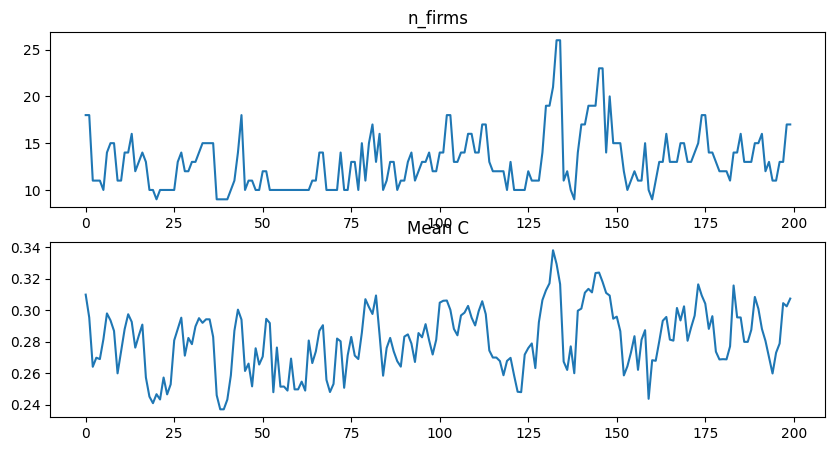

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result["C_mean"])

In [58]:
#ШОК СТАВОЧКИ

for i in range(100, 200):
    df["r"][i] = 0.2

Noke.setData(df)
Noke.scenario(out = True)

epoch0, number of firms: 11, entrats: 15, exiters: 14, EP: 0.0010276404037061395, C_mean: 0.26050975204170645, EP_fact: -0.0018050451915002411
epoch1, number of firms: 11, entrats: 0, exiters: 0, EP: 0.007021893322334124, C_mean: 0.29257658044622775, EP_fact: 0.008257713295399509
epoch2, number of firms: 11, entrats: 4, exiters: 4, EP: 0.001193619858476807, C_mean: 0.261537948693872, EP_fact: 0.002833795626548634
epoch3, number of firms: 11, entrats: 0, exiters: 0, EP: 0.004844043000822154, C_mean: 0.2819583813117657, EP_fact: 0.007327287996077819
epoch4, number of firms: 10, entrats: 4, exiters: 5, EP: 0.0006345142959910573, C_mean: 0.24661771054439313, EP_fact: 0.004357425031738602
epoch5, number of firms: 10, entrats: 0, exiters: 0, EP: 0.0014514086863932577, C_mean: 0.25177822141345374, EP_fact: 0.010050123942560992
epoch6, number of firms: 10, entrats: 0, exiters: 0, EP: 0.003991767831447075, C_mean: 0.2664049173789723, EP_fact: 0.012137611198608799
epoch7, number of firms: 13, en

C:\Users\user\AppData\Local\Temp\ipykernel_11272\1158626001.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["r"][i] = 0.2
C:\Users\user\AppData\Local\Temp\ipykernel_11272\1158626001.py:4: SettingWithCopyWarning: 
A value is trying to 

In [59]:
result2 = Noke.getData()
result2

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.097622,11,-0.001805,0.001028,0.260510,0.374277,15,14
1,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.052410,11,0.008258,0.007022,0.292577,0.401411,0,0
2,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.081984,11,0.002834,0.001194,0.261538,0.375147,4,4
3,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.060875,11,0.007327,0.004844,0.281958,0.392426,0,0
4,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.030467,10,0.004357,0.000635,0.246618,0.372181,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.2,0.4,1,10,0.01,0.1,0.20,0.8,0.081128,10,0.010732,0.011421,0.300987,0.417489,0,0
196,0.2,0.4,1,10,0.01,0.1,0.20,0.8,0.068528,10,0.010747,0.010512,0.297221,0.414351,0,0
197,0.2,0.4,1,10,0.01,0.1,0.20,0.8,0.063071,10,0.010798,0.007894,0.285752,0.404793,0,0
198,0.2,0.4,1,10,0.01,0.1,0.20,0.8,0.047362,10,0.007138,0.018270,0.326635,0.438863,0,0


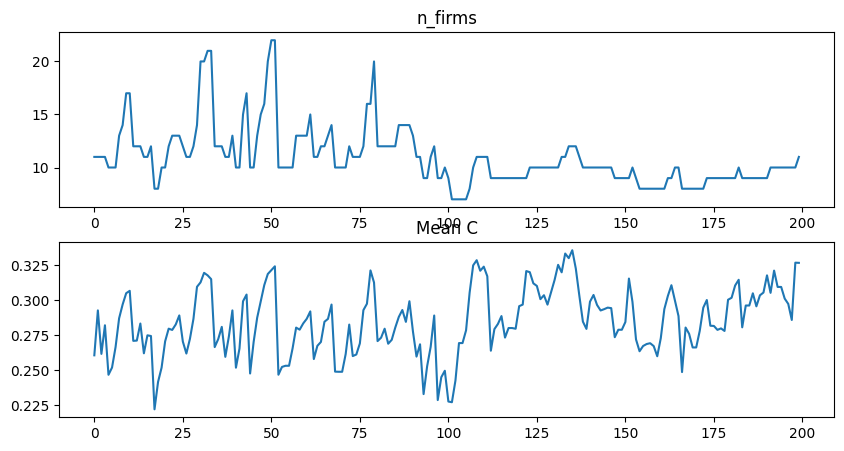

In [60]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [61]:
#СТАВОЧКУ НА РОДИНУ

for i in range(100, 200):
    df["r"][i] = 0.02

C:\Users\user\AppData\Local\Temp\ipykernel_11272\2385421624.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["r"][i] = 0.02
C:\Users\user\AppData\Local\Temp\ipykernel_11272\2385421624.py:4: SettingWithCopyWarning: 
A value is trying to

In [64]:
#ШОК КОСТОВ

for i in range(100, 200):
    df["f"][i] = 0.02

Noke.setData(df)
Noke.scenario(out = True)

epoch0, number of firms: 13, entrats: 6, exiters: 3, EP: 0.0011431053009661046, C_mean: 0.2787118798921054, EP_fact: 0.0013519643622053785
epoch1, number of firms: 13, entrats: 0, exiters: 0, EP: 0.0036779309900761576, C_mean: 0.29298013352029995, EP_fact: 0.004609687243800175
epoch2, number of firms: 10, entrats: 3, exiters: 6, EP: 0.0007923829729007265, C_mean: 0.24763510151214038, EP_fact: 0.003717710979448952
epoch3, number of firms: 10, entrats: 0, exiters: 0, EP: 0.0025104686097893146, C_mean: 0.2581153268789157, EP_fact: 0.012416708873382434
epoch4, number of firms: 11, entrats: 1, exiters: 0, EP: 0.007745021582699794, C_mean: 0.29590132765364785, EP_fact: 0.009975004661329332
epoch5, number of firms: 14, entrats: 3, exiters: 0, EP: 0.0036618817881276747, C_mean: 0.29962992352816537, EP_fact: 0.004361201694266069
epoch6, number of firms: 17, entrats: 3, exiters: 0, EP: 0.0012369280386999772, C_mean: 0.30188756735980155, EP_fact: -9.614632599939127e-05
epoch7, number of firms: 14

C:\Users\user\AppData\Local\Temp\ipykernel_11272\1633558980.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["f"][i] = 0.02
C:\Users\user\AppData\Local\Temp\ipykernel_11272\1633558980.py:4: SettingWithCopyWarning: 
A value is trying to

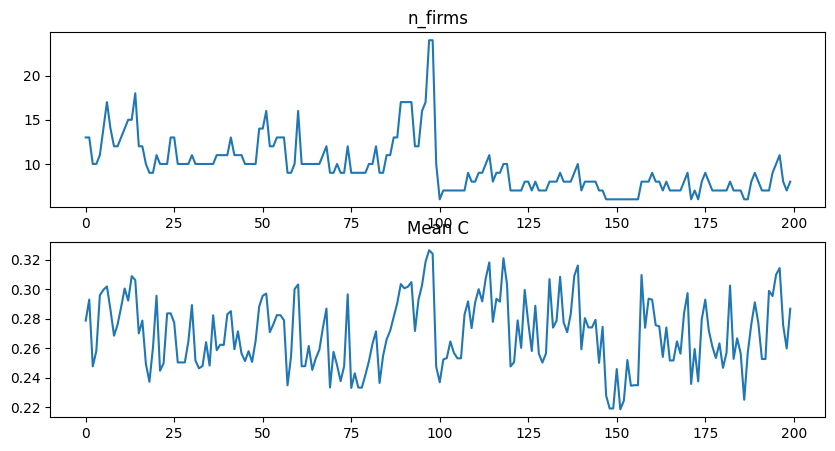

In [65]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [33]:
#КОСТЫ НА РОДИНУ

for i in range(100, 200):
    df["f"][i] = 0.01

C:\Users\user\AppData\Local\Temp\ipykernel_11272\3126581822.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["f"][i] = 0.01
C:\Users\user\AppData\Local\Temp\ipykernel_11272\3126581822.py:4: SettingWithCopyWarning: 
A value is trying to

In [36]:
#ШОК КОСТОВ ВХОДА

for i in range(100, 200):
    df["ef"][i] = 0.3

Noke.setData(df)
Noke.scenario(out = False)

C:\Users\user\AppData\Local\Temp\ipykernel_11272\1992166473.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["ef"][i] = 0.3
C:\Users\user\AppData\Local\Temp\ipykernel_11272\1992166473.py:4: SettingWithCopyWarning: 
A value is trying to

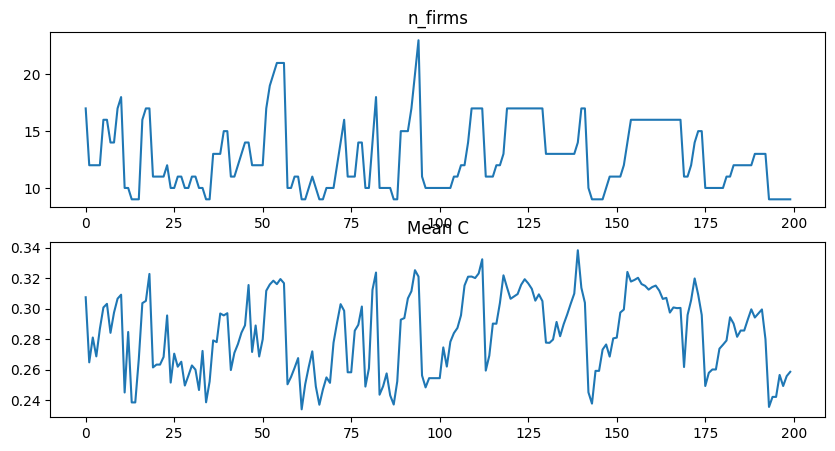

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [39]:
#ШОК КОСТОВ ВХОДА НА РОДИНУ

for i in range(100, 200):
    df["ef"][i] = 0.1


# ТЕХНОШОК
for i in range(100, 200):
    df["param_0"][i] = 0.1
    df["param_1"][i] = 0.3

df

C:\Users\user\AppData\Local\Temp\ipykernel_11272\4072437640.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["ef"][i] = 0.1
C:\Users\user\AppData\Local\Temp\ipykernel_11272\4072437640.py:4: SettingWithCopyWarning: 
A value is trying to

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.057170,17,0.000066,0.002238,0.307543,0.380433,7,0
1,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.052886,12,-0.000278,0.000210,0.264838,0.369861,1,6
2,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.010731,12,0.004612,0.002941,0.281127,0.383823,0,0
3,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.035341,12,0.003646,0.000829,0.268764,0.373226,1,1
4,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.042294,12,0.004752,0.004002,0.286836,0.388717,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.1,0.3,1,10,0.01,0.1,0.02,0.8,0.109279,9,0.014860,0.002143,0.242178,0.379964,0,0
196,0.1,0.3,1,10,0.01,0.1,0.02,0.8,0.109279,9,0.013801,0.004687,0.256576,0.391744,0,0
197,0.1,0.3,1,10,0.01,0.1,0.02,0.8,0.239022,9,0.013923,0.003364,0.249317,0.385805,0,0
198,0.1,0.3,1,10,0.01,0.1,0.02,0.8,0.171552,9,0.013831,0.004546,0.255824,0.391129,0,0


In [42]:
Noke.setData(df)
Noke.scenario(out = False)

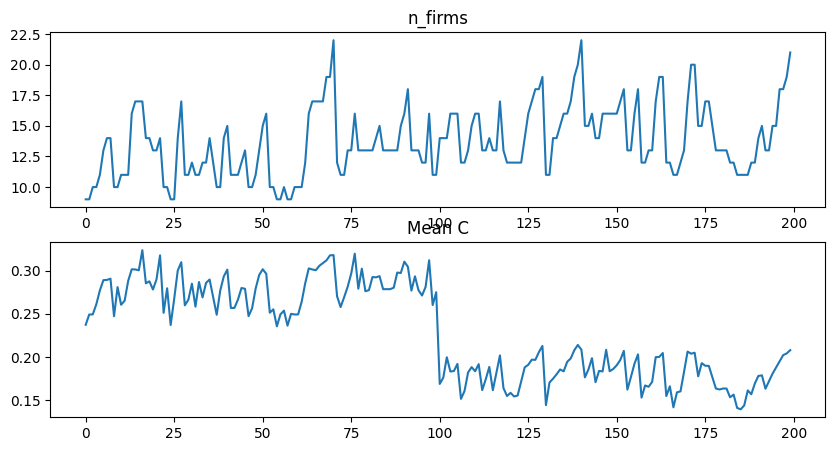

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [47]:
# ТЕХНОШОК НА РОДИНУ
for i in range(100, 200):
    df["param_0"][i] = 0.2
    df["param_1"][i] = 0.4

# ШОК СПРОСА

for i in range(100, 200):
    df["S"][i] = 30

df

C:\Users\user\AppData\Local\Temp\ipykernel_11272\627111058.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["param_0"][i] = 0.2
C:\Users\user\AppData\Local\Temp\ipykernel_11272\627111058.py:3: SettingWithCopyWarning: 
A value is trying

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.031174,12,0.001328,0.001060,0.270189,0.374448,6,4
1,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.054062,12,0.005282,0.003552,0.284454,0.386675,0,0
2,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.045901,11,0.004143,0.001200,0.261576,0.375179,2,3
3,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.061186,11,0.007564,0.003087,0.272608,0.384514,0,0
4,0.2,0.4,1,10,0.01,0.1,0.02,0.8,0.071453,11,0.004846,0.001008,0.260389,0.374176,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.2,0.4,1,30,0.01,0.1,0.02,0.8,0.065368,19,0.003680,0.002382,0.290686,0.358240,1,0
196,0.2,0.4,1,30,0.01,0.1,0.02,0.8,0.026807,21,0.002300,0.006253,0.313571,0.373260,2,0
197,0.2,0.4,1,30,0.01,0.1,0.02,0.8,0.098440,27,0.000768,0.002222,0.309964,0.357553,6,0
198,0.2,0.4,1,30,0.01,0.1,0.02,0.8,0.070785,28,0.000380,0.002116,0.311177,0.357098,1,0


In [48]:
Noke.setData(df)
Noke.scenario(out = False)

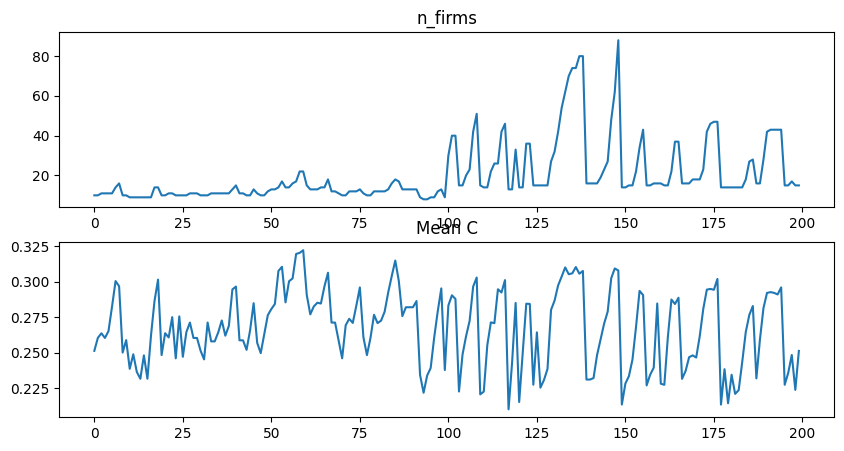

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])